# IBM Advanced Data Science Capstone Project
## Sentiment Analysis of Amazon Customer Reviews
### Harsh V Singh, Apr 2021

## Model Definition

In this notebook, we will define the machine learning model that will be used to train and predict the sentiment of an Amazon customer's review given its review heading and text. We have already preprocessed the raw data into a training set containing tokenized and vectorized features of the review text content along with a binary review sentiment which is 1 for positive and 0 for negative reviews.

## Importing required Python libraries and initializing Apache Spark environment

In [1]:
import numpy as np
import pandas as pd
import math
import time
import datetime
from pathlib import Path
import pickle
from scipy import sparse
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import sklearn
from sklearn.naive_bayes import ComplementNB
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Masking, Embedding
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import regularizers, optimizers, losses, metrics
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.autograph.set_verbosity(0)

import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext, SparkSession

conf = SparkConf().setMaster("local[*]") \
    .setAll([("spark.driver.memory", "24g"),\
             ("spark.executor.memory", "24g"), \
             ("spark.driver.maxResultSize", "24g"), \
             ("spark.executor.heartbeatInterval", "3600s"), \
             ("spark.network.timeout", "7200s")])
sc = SparkContext.getOrCreate(conf=conf)
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .getOrCreate()

import warnings
warnings.filterwarnings("ignore")

RUN_SAMPLE_CODE = True
TRAIN_FINAL_MODEL = True
SEED_NUMBER = 1324

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [2]:
# Function to print time taken by a particular process, given the start and end times
def printElapsedTime(startTime, endTime):
    elapsedTime = endTime - startTime
    print("-- Process time = %.2f seconds --"%(elapsedTime))

## Method 1: Training models using TFIDF vectorized data

First, we will use the TFIDF vectorized data to build a baseline Naive Bayes model and then train a neural network with 2 hidden layers.

### Loading TFIDF train/ test data

We will begin by loading the sample train/ test data.


In [3]:
if RUN_SAMPLE_CODE:
    sourceDir = Path("data/processedSamples/tfData")
    X_train_tf = sparse.load_npz(str(sourceDir.joinpath("X_train.npz")))
    X_test_tf = sparse.load_npz(str(sourceDir.joinpath("X_test.npz")))

    X_train_tf.sort_indices()
    X_test_tf.sort_indices()

    y_train_tf = pd.read_csv(str(sourceDir.joinpath("y_train.csv")))["review_sentiment"].to_numpy()
    y_test_tf = pd.read_csv(str(sourceDir.joinpath("y_test.csv")))["review_sentiment"].to_numpy()

    print("X_train_tf is of type %s and shape %s."%(type(X_train_tf), X_train_tf.shape))
    print("y_train_tf is of type %s, shape %s and %d unique classes."%(type(y_train_tf), y_train_tf.shape, len(np.unique(y_train_tf))))

X_train_tf is of type <class 'scipy.sparse.csr.csr_matrix'> and shape (31932, 75622).
y_train_tf is of type <class 'numpy.ndarray'>, shape (31932,) and 2 unique classes.


### Predictions using a Naive Bayes model for setting a performance baseline

**ComplementNB** implements the Complement Naive Bayes (CNB) algorithm. CNB is an adaptation of the standard multinomial naive Bayes (MNB) algorithm that is particularly suited for imbalanced data sets. CNB regularly outperforms MNB on text classification tasks so we will be using this model for our baseline.

In [4]:
if RUN_SAMPLE_CODE:
    tfCNBModel = ComplementNB().fit(X_train_tf, y_train_tf)
    print("ComplementNB Accuracy: %.2f%%"%(100 * sklearn.metrics.accuracy_score(y_test_tf, tfCNBModel.predict(X_test_tf))))

ComplementNB Accuracy: 81.16%


### Predictions using a Multi-layer Perceptron Neural Network

We will be using an **MLP** neural network with **two** hidden layers and a **sigmoid** activation for the output layer. We can experiment with the hyperparameters such as *L2 regularization, dropout rate, number of nodes in the hidden layers and the activation functions* to find the best possible combination that gives the best accuracy on the test data.

In [5]:
# Plot the model accuracy and loss over the training epochs
def plotTrainingPerformance(history, figTitle, figSize=(12,5)):
    fig = plt.figure(figsize=figSize)
    sns.set_theme()
    sns.set_style("white")
    
    metrics = history.model.metrics_names
    xvals = np.arange(len(history.history[metrics[0]])) + 1

    for i in range(len(metrics)):
        fig.add_subplot(1, len(metrics), i + 1)
        sns.lineplot(x=xvals, y=history.history[metrics[i]])
        sns.lineplot(x=xvals, y=history.history["val_" + metrics[i]])
        plt.xticks(xvals)
        plt.ylabel(metrics[i])
    
    fig.suptitle(figTitle)
    plt.show()

In [6]:
def getOutputPaths(modelName, modelsDir, logsDir):
    timeStampStr = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logPath = str(Path(logsDir).joinpath(modelName).joinpath(timeStampStr))
    modelPath = str(Path(modelsDir).joinpath(modelName).joinpath(timeStampStr)) + ".h5"
    return (modelPath, logPath)

In [7]:
# Function to compile, fit and predict keras model
def fitAndPredictModel(model, X_train, y_train, X_test, y_test, loss, optimizer, metrics, validationSplit, \
    epochs, batchSize, saveModel=True, modelsDir="data/models", logsDir="data/logs"):
    # Get dir paths for saving model and log files
    modelPath, logPath = getOutputPaths(modelName=model.name, modelsDir=modelsDir, logsDir=logsDir)
    # Compile the model
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    # Split training data into training/ validation sets
    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train.reshape(-1,1), test_size=validationSplit, shuffle= True)
    # TensorBoard callback
    tbCallback = TensorBoard(log_dir=logPath, update_freq="batch")
    # Model checkpoint callback
    monitorName = "val_" + (metrics[0] if isinstance(metrics[0], str) else metrics[0].name)
    cpCallback = ModelCheckpoint(modelPath, monitor=monitorName, verbose=1, save_best_only=True, mode="max")
    # Fit the model on the training data
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batchSize, validation_data=(X_valid, y_valid), callbacks=[tbCallback, cpCallback])
    # Plot training performance
    if(epochs >= 3):
        plotTrainingPerformance(history=history, figTitle="Accuracy/ Loss over Epochs")
    # Predict review sentiments on the test data and check model accuracy
    if saveModel == True:
        model.save(modelPath, save_format="h5")
    
    print("Test accuracy")
    _, accuracy = model.evaluate(X_test, y_test.reshape((-1,1)))
    print("%s Accuracy: %.2f%%" % (model.name, accuracy*100))

In [8]:
if RUN_SAMPLE_CODE:
    # Model definition
    tfModel = Sequential(name="sampleMLP")
    l2Reg = 1e-3
    dropout = 0.2
    tfModel.add(Dense(256, input_shape=(X_train_tf.shape[1],), \
        kernel_regularizer=regularizers.l2(l2Reg), \
        bias_regularizer=regularizers.l2(l2Reg)))
    tfModel.add(Activation('relu'))
    tfModel.add(Dropout(dropout))
    tfModel.add(Dense(256, input_shape=(X_train_tf.shape[1],), \
        kernel_regularizer=regularizers.l2(l2Reg), \
        bias_regularizer=regularizers.l2(l2Reg)))
    tfModel.add(Activation('relu'))
    tfModel.add(Dropout(dropout))
    tfModel.add(Dense(1))
    tfModel.add(Activation('sigmoid'))

    print(tfModel.summary())
    

Model: "sampleMLP"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               19359488  
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
activation_1 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 25

Epoch 1/3
400/400 [==============================] - 108s 246ms/step - loss: 0.7054 - binary_accuracy: 0.7453 - val_loss: 0.6042 - val_binary_accuracy: 0.8370

Epoch 00001: val_binary_accuracy improved from -inf to 0.83701, saving model to data\models\sampleMLP\20210423-143740.h5
Epoch 2/3
400/400 [==============================] - 103s 256ms/step - loss: 0.5446 - binary_accuracy: 0.8635 - val_loss: 0.5928 - val_binary_accuracy: 0.8426

Epoch 00002: val_binary_accuracy improved from 0.83701 to 0.84265, saving model to data\models\sampleMLP\20210423-143740.h5
Epoch 3/3
400/400 [==============================] - 100s 250ms/step - loss: 0.5194 - binary_accuracy: 0.8780 - val_loss: 0.5875 - val_binary_accuracy: 0.8386

Epoch 00003: val_binary_accuracy did not improve from 0.84265


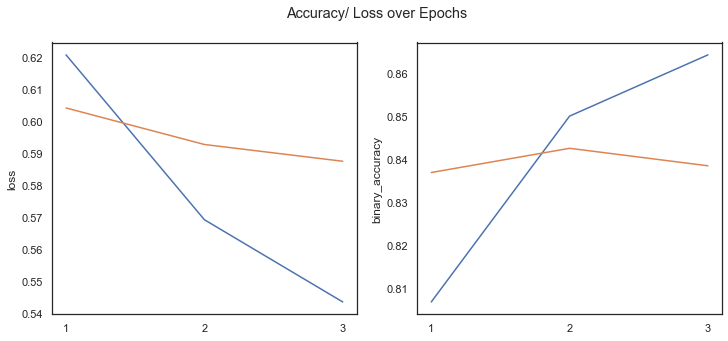

Test accuracy
250/250 [==============================] - 12s 48ms/step - loss: 0.5926 - binary_accuracy: 0.8357
sampleMLP Accuracy: 83.57%


In [9]:
if RUN_SAMPLE_CODE:
    # Compile, fit and predict model
    fitAndPredictModel(
        model=tfModel, X_train=X_train_tf, y_train=y_train_tf, X_test=X_test_tf, y_test=y_test_tf, 
        loss="binary_crossentropy", optimizer="adam", metrics=["binary_accuracy"], 
        validationSplit=0.2, epochs=3, batchSize=64)

## Method 2: Training models using sequential word vectors data

Now, we will use the sequential word vectors data to train a recurrent neural network with **2 LSTM layers**, **2 Dense layers** and a **sigmoid** output layer on the sample data. Since there are only ~50K samples in this dataset, we will use lower number of cells to avoid overfitting.

### Loading sample sequential train/ test data

We will begin by loading the train/ test data.

In [10]:
if RUN_SAMPLE_CODE:
    sourceDir = Path("data/processedSamples/seqData")
    X_train_seq = pd.DataFrame(np.load(str(sourceDir.joinpath("X_train.npy")), allow_pickle=True).tolist())
    X_test_seq = pd.DataFrame(np.load(str(sourceDir.joinpath("X_test.npy")), allow_pickle=True).tolist())
    y_train_seq = pd.read_csv(str(sourceDir.joinpath("y_train.csv")))["review_sentiment"].to_numpy()
    y_test_seq = pd.read_csv(str(sourceDir.joinpath("y_test.csv")))["review_sentiment"].to_numpy()

    vocabCount = max(X_train_seq.max(axis=1)) + 1

### Predictions using a LSTM Recurrent Neural Network

We will be using a **Recurrent neural network** with two LSTM layers, two fully-connected dense layers, and a **sigmoid** activation for the output layer. We can experiment with network architecture as well as the hyperparameters such as *L2 regularization, dropout rate, number of nodes in the hidden layers and the activation functions* to find the best possible combination that gives the best accuracy on the test data.

In [11]:
def getLSTMModel(modelName, inputDim, inputLength, l2Reg, outputDim=128, lstmCells=[128, 128], denseCells=[128, 64, 1]):
    # Model definition
    lstmModel = Sequential(name=modelName)
    lstmModel.add(Embedding(input_dim=inputDim, output_dim=outputDim, input_length=inputLength, mask_zero=True))
    lstmModel.add(LSTM(lstmCells[0], return_sequences=True))
    lstmModel.add(LSTM(lstmCells[1], return_sequences=False))
    lstmModel.add(Dense(denseCells[0], activation='relu', \
        kernel_regularizer=regularizers.l2(l2Reg), \
        bias_regularizer=regularizers.l2(l2Reg)))
    lstmModel.add(Dense(denseCells[1], activation='relu', \
        kernel_regularizer=regularizers.l2(l2Reg), \
        bias_regularizer=regularizers.l2(l2Reg)))
    lstmModel.add(Dense(denseCells[2], activation='sigmoid'))

    return (lstmModel)

In [12]:
if RUN_SAMPLE_CODE:
    # Set LSTM model hyperparameters
    l2Reg = 3e-3
    learningRate = 1e-3
    epochs = 3
    batchSize = 64
    validationSplit = 0.2

    lstmMetrics = [metrics.BinaryAccuracy()]
    lstmOptimizer = optimizers.Adam(learning_rate=learningRate)
    lstmLoss = losses.BinaryCrossentropy()

    sampleLSTMModel = getLSTMModel(modelName="sampleLSTM", inputDim=vocabCount, inputLength=X_train_seq.shape[1], l2Reg=l2Reg)
    print(sampleLSTMModel.summary())

Model: "sampleLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 123, 128)          4194304   
_________________________________________________________________
lstm (LSTM)                  (None, 123, 128)          131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 65        
Total params: 4,482,305
Trainable params: 4,482,305
Non-trainable params: 0
______________________________________________

Epoch 1/3
400/400 [==============================] - 130s 302ms/step - loss: 0.7799 - binary_accuracy: 0.7278 - val_loss: 0.4524 - val_binary_accuracy: 0.8059

Epoch 00001: val_binary_accuracy improved from -inf to 0.80586, saving model to data\models\sampleLSTM\20210423-144311.h5
Epoch 2/3
400/400 [==============================] - 110s 275ms/step - loss: 0.3177 - binary_accuracy: 0.8798 - val_loss: 0.3833 - val_binary_accuracy: 0.8486

Epoch 00002: val_binary_accuracy improved from 0.80586 to 0.84860, saving model to data\models\sampleLSTM\20210423-144311.h5
Epoch 3/3
400/400 [==============================] - 113s 284ms/step - loss: 0.1655 - binary_accuracy: 0.9465 - val_loss: 0.4206 - val_binary_accuracy: 0.8397

Epoch 00003: val_binary_accuracy did not improve from 0.84860


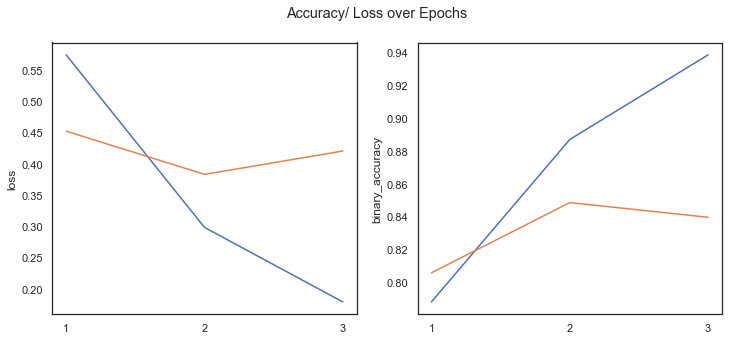

Test accuracy
250/250 [==============================] - 10s 40ms/step - loss: 0.4568 - binary_accuracy: 0.8288
sampleLSTM Accuracy: 82.88%


In [13]:
if RUN_SAMPLE_CODE:
    fitAndPredictModel(
        model=sampleLSTMModel, X_train=X_train_seq, y_train=y_train_seq, X_test=X_test_seq, y_test=y_test_seq, 
        loss=lstmLoss, optimizer=lstmOptimizer, metrics=lstmMetrics, validationSplit=validationSplit, epochs=epochs, batchSize=batchSize)

We are getting roughly the same performance from the MLP and LSTM models using the sample data. Since we have a fairly large dataset, we prefer to use the more complex LSTM model as our final choice. When we train the final model on the whole dataset, we should be able to significantly improve performance compared to the sample results and also train a more complex model without the risk of overfitting.

## Final Model - Keras LSTM Model with Padded Sequential Feature Vectors

In [14]:
if TRAIN_FINAL_MODEL:
    sourceDir = Path("data/processedData")
    trainSeq = spark.read.parquet(str(sourceDir.joinpath("trainSeq.parquet")))
    testSeq = spark.read.parquet(str(sourceDir.joinpath("testSeq.parquet")))
    print("There are %d samples in the training data and %d samples in the test data."%(trainSeq.count(), testSeq.count()))
    trainSeq.show(5)

There are 2394076 samples in the training data and 518715 samples in the test data.
+--------------------+----------------+
|            features|review_sentiment|
+--------------------+----------------+
|[0, 0, 0, 0, 0, 0...|               0|
|[0, 0, 0, 0, 0, 0...|               0|
|[0, 0, 0, 0, 0, 0...|               1|
|[0, 0, 0, 0, 0, 0...|               0|
|[0, 0, 0, 0, 0, 0...|               1|
+--------------------+----------------+
only showing top 5 rows



In [15]:
def getModellingData(sparkDF):
    df = sparkDF.toPandas()
    X = pd.DataFrame(df["features"].to_list())
    y = df["review_sentiment"].to_numpy()
    return (X, y)

In [16]:
if TRAIN_FINAL_MODEL:
    startTime = time.time()
    X_train, y_train = getModellingData(trainSeq)
    X_test, y_test = getModellingData(testSeq)

    # Load tokenizer model to get vocabulary count
    with open(str(sourceDir.joinpath("vectorTokenizer.pickle")), "rb") as handle:
        tokenizer = pickle.load(handle)
    
    tokConfig = tokenizer.get_config()
    vocabCount = tokConfig["num_words"]
    endTime = time.time()
    printElapsedTime(startTime=startTime, endTime=endTime)

-- Process time = 167.55 seconds --


### Predictions using an LSTM Recurrent Neural Network

As our final model, we will be using a **Recurrent neural network** with two LSTM layers, two fully-connected dense layers, and a **sigmoid** activation for the output layer. We can experiment with network architecture as well as the hyperparameters such as *L2 regularization, dropout rate, number of nodes in the hidden layers and the activation functions* to find the best possible combination that gives the best accuracy on the test data. 

*Given that it takes ~15 hours to train the model, we will not be including any hyperparameter tuning at this stage.*

In [17]:
if TRAIN_FINAL_MODEL:
    # Set LSTM model hyperparameters
    l2Reg = 1e-6
    learningRate = 3e-3
    epochs = 2
    batchSize = 256
    validationSplit = 0.1
        
    lstmMetrics = [metrics.BinaryAccuracy()]
    lstmOptimizer = optimizers.Adam(learning_rate=learningRate)
    lstmLoss = losses.BinaryCrossentropy()

    finalLSTMModel = getLSTMModel(
        modelName="finalLSTM", inputDim=vocabCount, inputLength=X_train.shape[1], 
        l2Reg=l2Reg, outputDim=128, lstmCells=[512, 256], denseCells=[256, 128, 1])
    print(finalLSTMModel.summary())

Model: "finalLSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 147, 128)          4194304   
_________________________________________________________________
lstm_2 (LSTM)                (None, 147, 512)          1312768   
_________________________________________________________________
lstm_3 (LSTM)                (None, 256)               787456    
_________________________________________________________________
dense_6 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_7 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
Total params: 6,393,345
Trainable params: 6,393,345
Non-trainable params: 0
_______________________________________________

In [18]:
if TRAIN_FINAL_MODEL:
    fitAndPredictModel(
        model=finalLSTMModel, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, 
        loss=lstmLoss, optimizer=lstmOptimizer, metrics=lstmMetrics, validationSplit=validationSplit, 
        epochs=epochs, batchSize=batchSize)

Epoch 1/2
8417/8417 [==============================] - 57102s 7s/step - loss: 0.2843 - binary_accuracy: 0.8800 - val_loss: 0.2175 - val_binary_accuracy: 0.9129

Epoch 00001: val_binary_accuracy improved from -inf to 0.91290, saving model to data\models\finalLSTM\20210423-145842.h5
Epoch 2/2
8417/8417 [==============================] - 58195s 7s/step - loss: 0.1940 - binary_accuracy: 0.9235 - val_loss: 0.2076 - val_binary_accuracy: 0.9169

Epoch 00002: val_binary_accuracy improved from 0.91290 to 0.91694, saving model to data\models\finalLSTM\20210423-145842.h5
Test accuracy
16210/16210 [==============================] - 8570s 529ms/step - loss: 0.2064 - binary_accuracy: 0.9179
finalLSTM Accuracy: 91.79%


In [ ]:
spark.SparkContext.stop()